In [1]:
"""
    This is a toy example that demonstrates how we can use LRP on a convolutional neural network trained on mnist
"""

%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import lrp
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 8, 10
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)


Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [2]:
#Build the Convolutional Neural Network
batch_size = 50
total_batch = int(mnist.train.num_examples/batch_size)
num_epochs = 5

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10], name="truth")

#Set the weights for the network
xavier = tf.contrib.layers.xavier_initializer_conv2d()  
conv1_weights = tf.get_variable(name="c1", initializer=xavier, shape=[5, 5, 1, 10])
conv1_biases = tf.Variable(tf.zeros([10]))
conv2_weights = tf.get_variable(name="c2", initializer=xavier, shape=[5, 5, 10, 25])
conv2_biases = tf.Variable(tf.zeros([25]))
conv3_weights = tf.get_variable(name="c3", initializer=xavier, shape=[4, 4, 25, 100])
conv3_biases = tf.Variable(tf.zeros([100]))
fc1_weights = tf.Variable(tf.truncated_normal([4 * 4 * 100, 10], stddev=0.1))
fc1_biases = tf.Variable(tf.zeros([10]))

#Stack the Layers
reshaped_input = tf.reshape(x, [-1, 28, 28, 1], name="absolute_input")
#layer 1
conv1 = tf.nn.conv2d(reshaped_input, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],  padding='SAME')
#layer 2
conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#layer 3
conv3 = tf.nn.conv2d(pool2, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
pool3 = tf.nn.max_pool(relu3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#layer 4    
pool_shape = pool3.get_shape().as_list()
reshaped = tf.reshape(pool3, [-1, pool_shape[1] * pool_shape[2] * pool_shape[3]])
y = tf.add(tf.matmul(reshaped, fc1_weights), fc1_biases, name="absolute_output")

# Define loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y, labels = y_))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)

# Train the model
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
# for i in (range(num_epochs)):
for i in tqdm(range(num_epochs)):
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_x, y_: batch_y})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
test_acc = []
train_acc = []
# for i in (range(total_batch)):
for i in tqdm(range(total_batch)):
    batch_x, batch_y = mnist.test.next_batch(batch_size)
    test_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y}))
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    train_acc.append(sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y}))
print (np.mean(train_acc), np.mean(test_acc) )

100%|██████████| 1100/1100 [00:26<00:00, 41.98it/s]

0.996964 0.992236


In [143]:
print('batch size:',batch_x.shape)
order_ind = np.arange(batch_x.shape[0])
np.random.shuffle(order_ind)
show_num = 3
show_batch_x = batch_x[order_ind[0:show_num],:]
show_batch_y = batch_y[order_ind[0:show_num],:]

batch size: (50, 784)


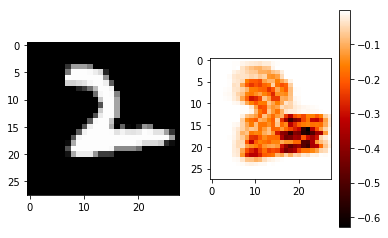

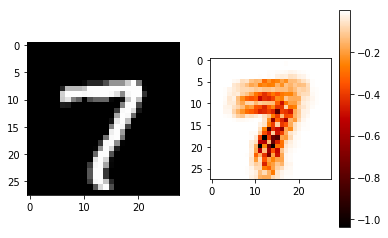

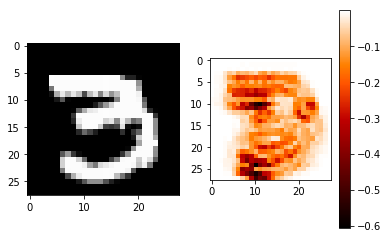

In [144]:
#Run LRP with Deep Taylor Decomposition on the output of the network
F_list = lrp.lrp(y*y_, 0, 1, return_flist=True)
im_list = lrp.get_lrp_im(sess, F_list[-1], reshaped_input, y_, np.reshape(show_batch_x, (show_num, 28,28, 1)), show_batch_y)
#Visualize the produced heatmaps
for b, im in zip(show_batch_x, im_list):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(b, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(im, (28,28)), cmap="gist_heat")
    plt.colorbar()
    plt.show()

In [147]:
# adding salt-pepper noise
print('show_batch size:',show_batch_x.shape)

noise_ratio = 0.1

show_batch_nx = np.zeros_like(show_batch_x)

for i, image in enumerate(show_batch_x):
    show_batch_nx[i] = image
    
    pix_ind = np.arange(image.shape[0])
    noise_num = int( image.shape[0]*noise_ratio )
    np.random.shuffle(pix_ind)
    
    b = np.zeros((noise_num, 784))
    b[np.arange(noise_num), pix_ind[0:noise_num]] = 1
    sum_b = np.sum(b, axis=0).astype(bool)
    c = np.zeros((noise_num, 784))
    c[np.arange(noise_num), pix_ind[noise_num:2*noise_num]] = 1
    sum_c = np.sum(b, axis=0).astype(bool)
    
    show_batch_nx[i][sum_b] = 0
    show_batch_nx[i][sum_c] = 1

show_batch size: (3, 784)


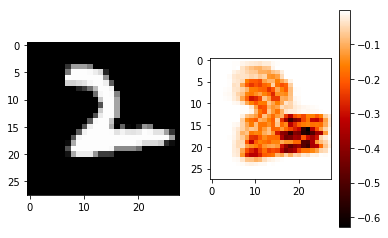

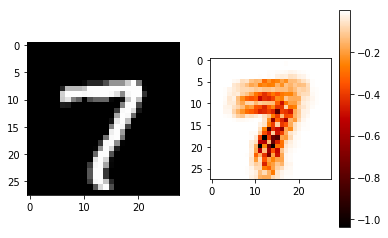

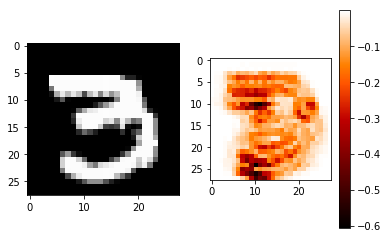

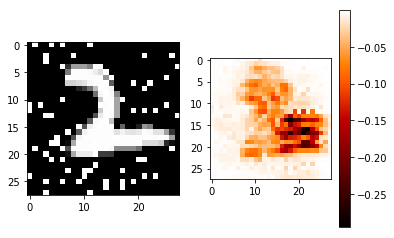

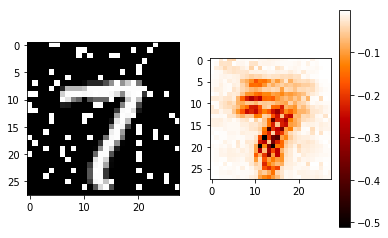

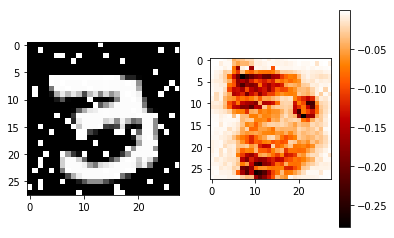

In [148]:
#Run LRP with Deep Taylor Decomposition on the output of the network
F_list = lrp.lrp(y*y_, 0, 1, return_flist=True)
im_list_n = lrp.get_lrp_im(sess, F_list[-1], reshaped_input, y_, np.reshape(show_batch_nx, (show_num, 28,28, 1)), show_batch_y)
#Visualize the produced heatmaps
for b, im in zip(show_batch_x, im_list):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(b, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(im, (28,28)), cmap="gist_heat")
    plt.colorbar()
    plt.show()


for b, im in zip(show_batch_nx, im_list_n):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(b, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(im, (28,28)), cmap="gist_heat")
    plt.colorbar()
    plt.show()

In [ ]:
# adding adversarial attack (L0-norm attack?)